In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [3]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 50, 50, 3])
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('ESRGAN.tflite', 'wb') as f:
  f.write(tflite_model)

esrgan_model_path = './ESRGAN.tflite'

In [15]:
#path of image
test_img_path = '/content/drive/MyDrive/AI ML Trainee/Damage Detection/Scratch/0017.jpg'

In [16]:
lr = tf.io.read_file(test_img_path)  #reading the file
lr = tf.image.decode_jpeg(lr) 
lr = tf.image.resize(lr,(50,50))
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=esrgan_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run the model
interpreter.set_tensor(input_details[0]['index'], lr)
interpreter.invoke()

# Extract the output and postprocess it
output_data = interpreter.get_tensor(output_details[0]['index'])
sr = tf.squeeze(output_data, axis=0)
sr = tf.clip_by_value(sr, 0, 255)
sr = tf.round(sr)
sr = tf.cast(sr, tf.uint8)

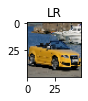

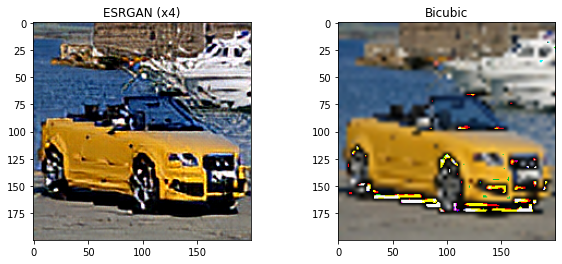

In [17]:
lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)
plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr.numpy());

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'ESRGAN (x4)')
plt.imshow(sr.numpy());

bicubic = tf.image.resize(lr, [200, 200], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());